In [12]:
!pip install gym
!pip install pygame
!pip install tf_agents==0.15.0
!pip install tensorflow


[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [13]:
import gym
import numpy as np
import pygame
import time
import random
from gym import spaces
from gym.envs.registration import register
import matplotlib.pyplot as plt
import tensorflow as tf
from tf_agents.agents.dqn import dqn_agent
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import sequential
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.specs import tensor_spec
from tf_agents.utils import common

# player piece colors [player1, player2]
colors = ['#FF0000', '#0000FF']

# paths for each tile 1-35
node_combinations = [ 
    [(0,3), (1,5), (2,6), (4,7)], [(0,4), (1,5), (2,6), (3,7)], [(0,3), (1,6), (2,5), (4,7)], [(0,6), (1,5), (2,4), (3,7)],
    [(0,1), (2,3), (4,5), (6,7)], [(0,4), (1,5), (2,3), (6,7)], [(0,6), (1,5), (2,3), (4,7)], [(0,5), (1,4), (2,7), (3,6)],
    [(0,5), (1,4), (2,6), (3,7)], [(0,3), (1,4), (2,5), (6,7)], [(0,6), (1,4), (2,5), (3,7)], [(0,5), (1,4), (2,3), (6,7)],
    [(0,2), (1,3), (4,6), (5,7)], [(0,2), (1,3), (4,5), (6,7)], [(0,5), (1,3), (2,7), (4,6)], [(0,6), (1,3), (2,7), (4,5)],
    [(0,4), (1,3), (2,6), (5,7)], [(0,5), (1,3), (2,6), (4,7)], [(0,4), (1,3), (2,5), (6,7)], [(0,6), (1,3), (2,5), (4,7)],
    [(0,5), (1,3), (2,4), (6,7)], [(0,6), (1,3), (2,4), (5,7)], [(0,3), (1,2), (4,7), (5,6)], [(0,3), (1,2), (4,6), (5,7)],
    [(0,3), (1,2), (4,5), (6,7)], [(0,4), (1,2), (3,7), (5,6)], [(0,5), (1,2), (3,7), (4,6)], [(0,6), (1,2), (3,7), (4,5)],
    [(0,4), (1,2), (3,6), (5,7)], [(0,5), (1,2), (3,6), (4,7)], [(0,4), (1,2), (3,5), (6,7)], [(0,6), (1,2), (3,5), (4,7)],
    [(0,5), (1,2), (3,4), (6,7)], [(0,6), (1,2), (3,4), (5,7)], [(0,7), (1,2), (3,4), (5,6)]
]


In [14]:
class Tile():
    def __init__(self, tile_num, tile_connections):
        self.tile_num = tile_num
        self.image = pygame.image.load("TsuroImages/" + str(tile_num) + ".png")
        self.image = pygame.transform.scale(self.image, (100, 100))
        self.tile_connections = tile_connections
        self.rotation = 1
    
    def move(self, current_node):
        next_node = 0
        next_player_tile = 0
        for connection in self.tile_connections:
            if current_node in connection:
                n1, n2 = connection
                if n1 == current_node:
                    next_node, next_player_tile, next_x, next_y = self.new_tile_node(n2)
                else:
                    next_node, next_player_tile, next_x, next_y = self.new_tile_node(n1)
                return next_node, next_player_tile, next_x, next_y
        raise Exception("Issue in moving players")
    
    # update number of times rotation should be applied to connections and image
    def rotate_tile(self, rotate):
        self.image = pygame.transform.rotate(self.image, rotate * -90)
        self.tile_connections = [tuple((element + (2 * rotate)) % 8 for element in couple ) for couple in self.tile_connections]
        self.rotation = 1 if (self.rotation + 1 % 4 == 0) else self.rotation + 1
        
    def get_rotation(self):
        return self.rotation
    
    def new_tile_node(self, current_node):
        next_node = 0
        next_x = 0
        next_y = 0
        next_player_tile = 0
        match current_node:
            case 0:
                next_node = 3
                next_player_tile = -1
                next_x = -1
            case 1:
                next_node = 6
                next_player_tile = -6
                next_y = -1
            case 2:
                next_node = 5
                next_player_tile = -6
                next_y = -1
            case 3:
                next_node = 0
                next_player_tile = 1
                next_x = 1
            case 4:
                next_node = 7
                next_player_tile = 1
                next_x = 1
            case 5:
                next_node = 2
                next_player_tile = 6
                next_y = 1
            case 6:
                next_node = 1
                next_player_tile = 6
                next_y = 1
            case 7:
                next_node = 4
                next_player_tile = -1
                next_x = -1
            case _:
                raise Exception("Issue in tile board")
                
        return next_node, next_player_tile, next_x, next_y
    

In [15]:
class TsuroEnv(gym.Env):
    #
    def __init__(self):
        self.screen = None
        self.current_player = 1
        self.num_tiles = 35
        self.tile_board_size = (6, 6)
        self.rotation_board_size = (6, 6)
        self.player_board_size = (36,8)
        self.num_players = 2
        self.tiles = []
        for i in range(self.num_tiles):
            self.tiles.append(Tile(i, node_combinations[i]))
            
        self.remaining_tiles = []
        for i in range(self.num_tiles):
            self.remaining_tiles.append(i)
        random.shuffle(self.remaining_tiles)

        self.remaining_players = []
        for i in range(self.num_players):
            self.remaining_players.append(i+1)
        
        self.player_tiles = []
        for i in range(self.num_players):
            player_tiles = []
            for i in range(3):
                player_tiles.append(self.remaining_tiles.pop())
            self.player_tiles.append(player_tiles)
            
        self.rotation_board = np.zeros(self.rotation_board_size, dtype = int)
        self.tile_board = np.zeros(self.tile_board_size, dtype = int)
        self.player_board = np.zeros(self.player_board_size, dtype = int)

        self.action_space = spaces.Discrete(11)
        self.observation_space = spaces.Box(low=-1, high=140, shape=(327,))
        
    def get_tile_obs(self):
        temp = self.rotation_board.flatten()
        temp1 = self.tile_board.flatten()
        for i in range(35):
            temp[i] = ((temp[i] - 1) * 35) + temp1[i]
        return temp
        
    # Resets the environment to default state
    def reset(self): 
        self.current_player = 1
        self.rotation_board = np.zeros(self.rotation_board_size, dtype = int)
        self.tile_board = np.zeros(self.tile_board_size, dtype = int)
        self.player_board = np.zeros(self.player_board_size, dtype = int)
        
        self.tiles = []
        for i in range(self.num_tiles):
            self.tiles.append(Tile(i, node_combinations[i]))
            
        self.remaining_tiles = []
        for i in range(self.num_tiles):
            self.remaining_tiles.append(i)
        random.shuffle(self.remaining_tiles)
            
        self.remaining_players = []
        for i in range(self.num_players):
            self.remaining_players.append(i+1)
            
        self.player_tiles = []
        for i in range(self.num_players):
            player_tiles = []
            for i in range(3):
                player_tiles.append(self.remaining_tiles.pop())
            self.player_tiles.append(player_tiles)
            
        #########################################
        #TODO: TESTING STUFF TO BE REMOVED LATER#
        #########################################
        for i in range(self.num_players):
            self.player_board[random.randint(0,5)][i+1] = i+1
            
        initial_obs = np.hstack((self.player_tiles[self.current_player - 1], self.player_board.flatten(), self.get_tile_obs()))

        return initial_obs
    
    # Makes a move in the game based on inputs from player or AI
    def step(self, action = -2, move = -1):
        if move == -1:
            card, rotate = self.get_card(action)
        else:
            card = move
            rotate = 0
        
        action = self.player_tiles[self.current_player - 1][card]
        
        if action == -1:
            observation = np.hstack((self.player_tiles[self.current_player - 1], self.player_board.flatten(), self.get_tile_obs()))
            reward = -1
            done = 0
            return observation, reward, done, {}
            
        # Removes used tile and adds new tile from deck to hand
        self.player_tiles[self.current_player-1].remove(action)
        if len(self.remaining_tiles) > 0:
            self.player_tiles[self.current_player-1].append(self.remaining_tiles.pop())
        else:
            self.player_tiles[self.current_player-1].append(-1)
        
        # Rotates tile (Only used by AI)
        self.tiles[action].rotate_tile(rotate)
        
        reward = 0
        self.place_tile(action+1)
        self.move_players()
        reward = self.reward_function()
        if self.game_is_over():
            done = 1
        else:
            done = 0
        self.current_player = self.next_player()
        observation = np.hstack((self.player_tiles[self.current_player - 1], self.player_board.flatten(), self.get_tile_obs()))
        return observation, reward, done, {}
    
    # Decides if the game is over
    def game_is_over(self):
        if len(self.remaining_players) <= 1:
            return True
        return False
    
    # Decides the reward (Only used for AI)
    def reward_function(self):
        if not self.game_is_over():
            return 1
        if self.game_is_over() and self.current_player in self.remaining_players:
            return 2
        return -1
    
    # Places tile in self.tile_board
    def place_tile(self, tile):
        tile_number, node_number = np.where(self.player_board == self.current_player)
        x, y = TsuroEnv.euclidean_division(self, tile_number)
        x = x[0]
        y = y[0]
        self.tile_board[x][y] += tile
        self.rotation_board[x][y] += self.tiles[tile-1].get_rotation()
    
    # Moves player piece in self.player_board
    def move_players(self):
        for player in self.remaining_players:
            tile_number, node_number = np.where(self.player_board == player)
            x, y = TsuroEnv.euclidean_division(self, tile_number)
            x = x[0]
            y = y[0]
            while self.tile_board[x][y] != 0:
                tile = self.tiles[(self.tile_board[x][y])-1]
                next_node, next_player_tile, next_x, next_y = tile.move(node_number)
                self.player_board[tile_number[0]][node_number[0]] = 0
                if ((tile_number[0] % 6 == 0) and ((tile_number[0] + next_player_tile) % 6 == 5)) or (tile_number[0] + next_player_tile < 0) or (tile_number[0] + next_player_tile > 35) or ((tile_number[0] % 6 == 5) and ((tile_number[0] + next_player_tile) % 6 == 0)):
                    self.remaining_players.remove(player)
                    break
                else:
                    self.player_board[tile_number[0] + next_player_tile][next_node] = player
                    x += next_x
                    y += next_y
                    tile_number, node_number = np.where(self.player_board == player)
    
    # Quotient and Remainder
    def euclidean_division(self, x, y = 6):
        return x % y, x // y
    
    # Action (card, rotation) from input
    def get_card(self, x, y = 4):
        return  x // y, x % y

    # Decide whos turn it is
    def next_player(self):
        if len(self.remaining_players) == 0:
            return -1
        if self.current_player not in self.remaining_players:
            for player in self.remaining_players:
                if player > self.current_player:
                    return player
                else:
                    return self.remaining_players[0]
        return self.remaining_players[(self.remaining_players.index(self.current_player) + 1) % len(self.remaining_players)]
        
    # Render the environment
    def render(self, mode):
        screen = pygame.display.set_mode((650, 750))
        screen.fill((255, 255, 255))

        # Draw the game board
        board = pygame.image.load("TsuroImages/board.png")
        board = pygame.transform.scale(board, (600, 600))
        screen.blit(board, (25,25))
        
        # Draw current players hand
        for i in range (len(self.player_tiles[self.current_player-1])):
            tile = self.player_tiles[self.current_player-1][i]
            screen.blit(self.tiles[tile].image, (75 + (i * 200), 635))
        
        # Draw the tiles on the board
        for x in range(self.tile_board_size[0]):
            for y in range(self.tile_board_size[1]):
                val = self.tile_board[x][y]
                if val != 0:
                    tile = self.tiles[val-1]
                    screen.blit(tile.image, (25 + x * 100, 25 + y * 100))
                    
        # Draw the players' pieces on the board
        for i in self.remaining_players:
            tile_number, node_number = np.where(self.player_board == i)
            y_add = 0
            x_add = 0
            y_mult = 0
            x_mult = 0
            
            match node_number[0]:
                case 0:
                    y_add = 35
                case 1:
                    x_add = 35
                case 2:
                    x_add = 70
                case 3:
                    x_add = 100
                    y_add = 35
                case 4:
                    x_add = 100
                    y_add = 70
                case 5:
                    x_add = 70
                    y_add = 100
                case 6:
                    x_add = 35
                    y_add = 100
                case 7:
                     y_add = 70
                case _:
                    raise Exception("Issue in drawing the player board")
                    
            if tile_number[0] != 0:
                x_mult, y_mult = TsuroEnv.euclidean_division(self, tile_number[0])
            
            pygame.draw.circle(screen, colors[i-1], (25 + x_add + (100 * x_mult), 25 + y_add + (100 * y_mult)), 5)
            
        # Draw text to show who won when game is over
        if self.game_is_over() or self.current_player == -1:
            font = pygame.font.Font('freesansbold.ttf', 32)
            text = font.render('Player ' + str(self.current_player) + ' wins', True, '#00FF00')
            textRect = text.get_rect()
            textRect.center = (650 // 2, 750 // 2)
            screen.blit(text, textRect)
            
        pygame.display.update()



In [16]:
num_iterations = 2000000

initial_collect_steps = 10000
collect_steps_per_iteration = 1
replay_buffer_max_length = 100000

batch_size = 100
learning_rate = 1e-3
log_interval = 200

num_eval_episodes = 500
eval_interval = 5000

register(
    id='TsuroEnv',
    entry_point=TsuroEnv,
)

env_name = "TsuroEnv"

train_py_env = suite_gym.load(env_name)
eval_py_env = suite_gym.load(env_name)

train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

fc_layer_params = (200, 100)
action_tensor_spec = tensor_spec.from_spec(train_env.action_spec())
num_actions = action_tensor_spec.maximum - action_tensor_spec.minimum + 1

def dense_layer(num_units):
    return tf.keras.layers.Dense(num_units, activation=tf.keras.activations.relu, kernel_initializer=tf.keras.initializers.VarianceScaling(scale=2.0, mode='fan_in', distribution='truncated_normal'))

dense_layers = [dense_layer(num_units) for num_units in fc_layer_params]
q_values_layer = tf.keras.layers.Dense(num_actions, activation=None, kernel_initializer=tf.keras.initializers.RandomUniform(minval=-0.03, maxval=0.03), bias_initializer=tf.keras.initializers.Constant(-0.2))
q_net = sequential.Sequential(dense_layers + [q_values_layer])

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

train_step_counter = tf.Variable(0)

agent = dqn_agent.DqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter)

agent.initialize()

eval_policy = agent.policy
collect_policy = agent.collect_policy

random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())

replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_max_length)
    
def compute_avg_return(environment, policy, num_episodes=10):

    total_return = 0.0
    for _ in range(num_episodes):

        time_step = environment.reset()
        episode_return = 0.0

        while not time_step.is_last():
            action_step = policy.action(time_step)
            time_step = environment.step(action_step.action)
            episode_return += time_step.reward
        total_return += episode_return

    avg_return = total_return / num_episodes
    return avg_return.numpy()[0]

def collect_step(environment, policy, buffer):
    time_step = environment.current_time_step()
    action_step = policy.action(time_step)
    next_time_step = environment.step(action_step)
    # commenting out render will make training quicker
    # environment.render("human")
    traj = trajectory.from_transition(time_step, action_step, next_time_step)
    buffer.add_batch(traj)

def collect_data(env, policy, buffer, steps):
    for _ in range(steps):
        collect_step(env, policy, buffer)
        
train_checkpointer = common.Checkpointer(
    ckpt_dir="Checkpoints/",
    max_to_keep=1,
    agent=agent,
    policy=agent.policy,
    replay_buffer=replay_buffer,
    global_step=train_step_counter
)

train_checkpointer.initialize_or_restore()

C:\Users\HorridJoe\opencv\lib\site-packages\gym\envs\registration.py:595: UserWarning: WARN: Overriding environment TsuroEnv
  logger.warn(f"Overriding environment {id}")


In [17]:
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3, 
    sample_batch_size=batch_size, 
    num_steps=2).prefetch(3)

iterator = iter(dataset)

agent.train = common.function(agent.train)

returns = []

with open("Checkpoints/returns.txt", "r") as txt:
    for line in txt:
        returns.append(line)
        
for i in range(len(returns)):
    returns[i] = returns[i].strip()
    returns[i] = float(returns[i])


In [18]:
# Initial Collection for new agent
'''
collect_data(train_env, random_policy, replay_buffer, initial_collect_steps)
agent.train_step_counter.assign(0)

avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
returns = [avg_return]
'''

'\ncollect_data(train_env, random_policy, replay_buffer, initial_collect_steps)\nagent.train_step_counter.assign(0)\n\navg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)\nreturns = [avg_return]\n'

In [19]:
for _ in range(num_iterations):
    collect_data(train_env, agent.collect_policy, replay_buffer, collect_steps_per_iteration)

    experience, unused_info = next(iterator)
    train_loss = agent.train(experience).loss

    step = agent.train_step_counter.numpy()

    if step % log_interval == 0:
        print('step = {0}: loss = {1}'.format(step, train_loss))

    if step % eval_interval == 0:
        avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
        print('step = {0}: Average Return = {1}'.format(step, avg_return))
        returns.append(avg_return)
        train_checkpointer.save(train_step_counter)
        with open("Checkpoints/returns.txt", "w") as txt:
            for item in returns:
                txt.write(str(item) + "\n")


KeyboardInterrupt: 

(1.9252, 10.0)

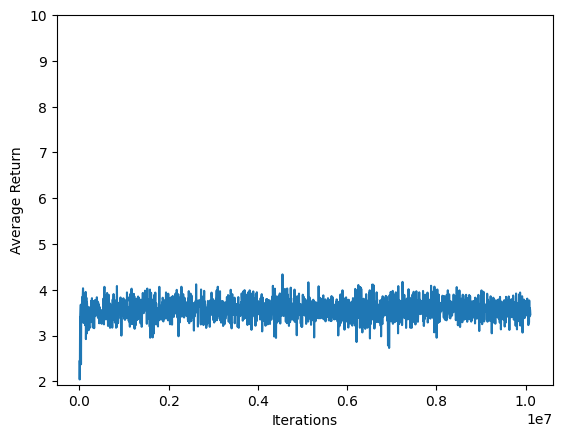

In [20]:
iterations = range(0, train_step_counter + 1, eval_interval)
plt.plot(iterations, returns)
plt.ylabel('Average Return')
plt.xlabel('Iterations')
plt.ylim(top = 10)